# **MA-CSSL Hate Speech Detection in Turkish using BERT - EPISODE 1 - Part 2: Fine Tuning a BERT Model for Turkish Hate Speech Detection**

# Importing the Libraries

You can install all the libraries that aren't currently on the notebook with the "!pip install [library-name]" command.

In [ ]:
#!pip install urlextract

In [56]:
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from collections import Counter
from sklearn.utils import resample
from transformers import BertConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer, ConvBertConfig
from torch.utils.data import DataLoader, Dataset


from sklearn.metrics import precision_recall_fscore_support, matthews_corrcoef
from transformers import get_linear_schedule_with_warmup
import random
from sklearn.utils.class_weight import compute_class_weight

# Reading the Training Data

Sabancı University HSD2-Lang Hate Speech Detection Competition Training Data https://drive.google.com/drive/folders/1K_B3_JN5jaVTSpntgzyUI48aFLiCp3fa?usp=drive_link

In [57]:
israel = pd.read_csv("/content/drive/MyDrive/hate-speech-sabancı/isr_pal_train.csv")
refugee = pd.read_csv("/content/drive/MyDrive/hate-speech-sabancı/refugee_train.csv")
greek = pd.read_csv("/content/drive/MyDrive/hate-speech-sabancı/tr_gr_train.csv")

## Concatenating

In [58]:
df = pd.concat([israel,refugee,greek], axis=0)

In [59]:
df.reset_index(inplace=True)

## Label Counts

In [84]:
df.shape

(8807, 4)

In [60]:
df["label"].value_counts()

0    6392
1    2748
Name: label, dtype: int64

# Using TweetBERT's preprocessor
https://github.com/ViralLab/TurkishBERTweet

In [61]:
%cd /content/drive/MyDrive/TurkishBERTweet/TurkishBERTweet

/content/drive/MyDrive/TurkishBERTweet/TurkishBERTweet


## Before Preprocessing

In [62]:
df["text"]

0                #Yıkılasınisrail https://t.co/Q002Qk4vWn
1       @1dirilis_genci @Svgl79865097 #AlAqsaUnderAtta...
2       Şehadetin mübarek olsun cennet kuşu🕊\n@yahyazn...
3       @AshrafS89866013 #Qəzzahücumaltındadır\n#Gazze...
4       Bugün ribat noktası, okçular tepesi Mescid-i A...
                              ...                        
9135    Şunu iyi bil Yunanistan!\n\nFıtrat değişir san...
9136    @username @username @username @username @usern...
9137    @username Türkiye Nato'dan çıkarsa bölgede bur...
9138    @username Bir gece ansızın gelebiliriz, hemde ...
9139    Meral Başkan askerin elinde ki G-3 Piyade tüfe...
Name: text, Length: 9140, dtype: object

In [63]:
from Preprocessor import preprocess
df['text'] = df['text'].apply(preprocess)

## After Preprocessing

In [64]:
df["text"][0]

'<hashtag> yıkılasınisrail </hashtag> <http> t.co </http>'

In [65]:
df["text"][1]

'@user @user <hashtag> alaqsaunderattack </hashtag> <hashtag> المسجد_الأقصي_بأعيننا </hashtag> <hashtag> freepalestine </hashtag> <hashtag> freeahmadmanasra </hashtag> <hashtag> aksadabaskınvar </hashtag> <hashtag> keepeyeonalaqsa </hashtag> <hashtag> gözümüzkulağımızaksada </hashtag> <hashtag> unchilding </hashtag>'

## Examining the Duplicates and their labels

In [66]:
duplicates = df[df.duplicated('text', keep=False)]
sorted_duplicates = duplicates.sort_values(by='text')
print(sorted_duplicates[['text', 'label']])

                                                   text  label
6489  "burada iç savaş var, suriyeliler yağmaya başl...      0
6412  "burada iç savaş var, suriyeliler yağmaya başl...      0
5557  "enkazdan ceset çıkarıp kenara koyuyoruz. bir ...      0
5519  "enkazdan ceset çıkarıp kenara koyuyoruz. bir ...      0
5594  "enkazdan ceset çıkarıp kenara koyuyoruz. bir ...      0
...                                                 ...    ...
7293  ülkemde mülteci istemiyorum <hashtag> ülkemdem...      0
7071  ülkemde mülteci istemiyorum <hashtag> ülkemdem...      0
9005  şunu iyi bil yunanistan! fıtrat değişir sanma!...      1
8728  şunu iyi bil yunanistan! fıtrat değişir sanma!...      1
9135  şunu iyi bil yunanistan! fıtrat değişir sanma!...      1

[848 rows x 2 columns]


You can see that some annotations are wrong.

In [67]:
grouped = sorted_duplicates.groupby('text')
conflicting_duplicates = grouped.filter(lambda x: set(x['label']) == {0, 1})
conflicting_duplicates

,index,id,text,label
23,23,1393361140265201666,<hashtag> bbc </hashtag> <hashtag> cnn </hasht...,1
139,139,1393360764153606149,<hashtag> bbc </hashtag> <hashtag> cnn </hasht...,0
229,229,1392914857821884416,<hashtag> kahrolsunisrail </hashtag> <http> t....,1
1672,1672,1394282105702653958,<hashtag> kahrolsunisrail </hashtag> <http> t....,0
333,333,1393698217372565504,<hashtag> kahrolsunisrail </hashtag> <http> t....,0
...,...,...,...,...
5,5,1392461844179206148,"uyan ey müslüman! i̇lk kıblen, mübarek mescid-...",0
658,658,1391767883747897350,"uyan ey müslüman! i̇lk kıblen, mübarek mescid-...",0
220,220,1391797816624914432,"uyan ey müslüman! i̇lk kıblen, mübarek mescid-...",0
426,426,1392433299486912513,"uyan ey müslüman! i̇lk kıblen, mübarek mescid-...",1


## Removing the conflicting duplicates

In [68]:
conflicting_indices = conflicting_duplicates.index
df = df.drop(conflicting_indices)
df

,index,id,text,label
0,0,1394972347308945410,<hashtag> yıkılasınisrail </hashtag> <http> t....,1
1,1,1516026054686633984,@user @user <hashtag> alaqsaunderattack </hash...,0
2,2,1393484053677056001,şehadetin mübarek olsun cennet kuşu🕊 @user <ha...,1
3,3,1392870740890988548,@user <hashtag> qəzzahücumaltındadır </hashtag...,0
4,4,1515696070386454529,"bugün ribat noktası, okçular tepesi mescid-i a...",0
...,...,...,...,...
9135,971,1566426636240797700,şunu iyi bil yunanistan! fıtrat değişir sanma!...,1
9136,972,1557681343940755457,@user @user @user @user @user hala daha siz be...,0
9137,973,1529934699187126307,@user türkiye nato'dan çıkarsa bölgede burun k...,0
9138,974,1568341795066580995,"@user bir gece ansızın gelebiliriz, hemde hery...",1


In [69]:
df["label"].value_counts()

0    6155
1    2652
Name: label, dtype: int64

# Hashtag Segmentation

In [70]:
import gzip
path_to_gz_file = "/content/drive/MyDrive/SETIMES/tr.txt.gz" #https://opus.nlpl.eu/SETIMES/bg&tr/v2/SETIMES
unzipped_file_path = "/content/drive/MyDrive/SETIMES/tr.txt"
with gzip.open(path_to_gz_file, 'rt', encoding='utf-8') as gzipped_file:
    with open(unzipped_file_path, 'w', encoding='utf-8') as unzipped_file:
        for line in gzipped_file:
            unzipped_file.write(line)
with open(unzipped_file_path, 'r', encoding='utf-8') as file:
    content = file.read()
print(content[:1000])

Hırvat yerel seçimleri ikinci tura kaldı
Sonuçlar, başta büyük şehirler olmak üzere açık farkla bir zafer elde edilmediğini gösterdi.
Ve seçim gözlemcileri seçim günü sandık merkezlerinde kampanya yasağının delindiğini bildirdiler.
Southeast European Times için Zagreb'den Natasa Radiç'in haberi -- 21/05/09
Hırvatlar 17 Mayıs Pazar günü yerel ve bölgesel seçimler için sandık başına gittiler. [Getty Images]
17 Mayıs Pazar günkü yerel seçimlerde sandıkların kapanmasından sonra, ilk sonuçlar büyük şehirler arasında sadece Rijeka'da seçmenlerin belediye başkanlarını ilk turda seçtiler.
Hırvatistan'ın diğer şehirlerinde hiçbir aday salt zafer elde edemedi.
Toplam 1,9 milyon oy kullanıldı.
Hırvatistan'ın 1991 yılındaki bağımsızlığından bu yana ilk defa seçmenler 21 eyalet meclisinin 866 üyesi, 126 il ve ilçe meclisinin 2 bin 206 üyesi ve 427 belediye meclisinin 5 bin 343 üyesini doğrudan oyla seçtiler.
Seçimlerde toplam 46 bin 325 aday yarıştı.
İlk resmi sonuçlar, iktidardaki Hırvat Demokrat 

In [71]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
tokens = tokenizer.tokenize(content)
lowercase_tokens = [token.lower() for token in tokens]
len(lowercase_tokens)

33144361

In [72]:
import nltk
from nltk.probability import FreqDist
nltk.download('punkt')
freq_dist = FreqDist(lowercase_tokens)
freq_dist

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


FreqDist({'ve': 856523, 'bir': 671742, 'da': 306073, 'bu': 274445, 'için': 238548, 'de': 231744, 'nin': 156881, 'ab': 150788, 'nın': 142821, 'ile': 128895, ...})

In [73]:
words_by_frequency= sorted(freq_dist,key= freq_dist.get,reverse=True)
words_by_frequency[:10]

['ve', 'bir', 'da', 'bu', 'için', 'de', 'nin', 'ab', 'nın', 'ile']

In [74]:
from math import log

wordcost = dict((word, log((rank+1)*log(len(freq_dist)))) for rank, word in enumerate(sorted(freq_dist, key=freq_dist.get, reverse=True)))
maxword = max(len(word) for word in freq_dist)

In [75]:
import re
def infer_spaces(s):
    """Infers the location of spaces in a Turkish string without spaces."""
    s = re.sub(r'[^a-zçöşüğı]', '', s.lower())

    def best_match(i):
        candidates = enumerate(reversed(cost[max(0, i-maxword):i]))
        return min((c + wordcost.get(s[i-k-1:i], float('inf')), k+1) for k,c in candidates)

    cost = [0]
    for i in range(1, len(s)+1):
        c, k = best_match(i)
        cost.append(c)

    out = []
    i = len(s)
    while i > 0:
        c, k = best_match(i)
        assert c == cost[i]
        out.append(s[i-k:i])
        i -= k

    return " ".join(reversed(out))

In [76]:
hashtag = "kudüsfilistininbaşkentidir"
print(infer_spaces(hashtag))

kudüs filistin in başkentidir


In [77]:
def process_hashtags(text, pattern=re.compile(r'<hashtag>(.*?)</hashtag>')):
    def replace(match):
        hashtag = match.group(1)
        spaced_hashtag = infer_spaces(hashtag)
        return f'<hashtag>{spaced_hashtag}</hashtag>'

    processed_text = pattern.sub(replace, text)
    return processed_text
df['text'] = df['text'].apply(process_hashtags)

In [78]:
df['text'].iloc[974]

'@user filistin’de zulüm varsa…! dünyada adalet yoktur. <hashtag>özgür filistin</hashtag> <hashtag>gazze ateş altında</hashtag> <hashtag>gaza under attack</hashtag> 𝓛𝓪 𝓖𝓪𝓵𝓲𝓫𝓮 𝓘̇𝓵𝓵𝓪𝓵𝓵𝓪𝓱 <http> t.co </http>'

In [79]:
df['text'].iloc[970]

"selalarla i̇srail'i durduruyoruz şuan. duyuyorlarmış ve duracaklarmış haha! uygur türkleri? onu boşverin çinden aşı gelecek, onun dışında ilişkiler önemli, para falans.. <hashtag>aksa da baskın var</hashtag>"

In [80]:
df['text'].iloc[950]

'@user @user <emoji> dalgın_yüz </emoji> <emoji> açık_eller_koyu_ten_tonu </emoji> <hashtag>mescid i aksa</hashtag> <hashtag>kudüs bizimdir</hashtag>'

#Train and Validation Split

It's better to do before the resampling. Otherwise the algorithm will try to predict things it's already seen before and it will skew your results. In our case, we didn't add the test data to the train data so we only need to split the train and validation sets.

In [82]:
from sklearn.model_selection import train_test_split

In [83]:
train_set,val_set = train_test_split(df, test_size=0.2, random_state=42)
(train_set.shape[0], val_set.shape[0])

(7045, 1762)

In [86]:
train_set["label"].value_counts()

0    4927
1    2118
Name: label, dtype: int64

In [87]:
val_set["label"].value_counts()

0    1228
1     534
Name: label, dtype: int64

# Resampling the Training Set

In [85]:
from sklearn.utils import resample

In [90]:
def resample_to_majority_class(df):
    class_counts = train_set['label'].value_counts()
    majority_class = class_counts.idxmax()
    majority_class_count = class_counts.max()
    resampled_dfs = []
    for class_label in train_set['label'].unique():
        class_df = df[train_set['label'] == class_label]
        resampled_class_df = resample(class_df,
                                      replace=True,
                                      n_samples=majority_class_count,
                                      random_state=42)
        resampled_dfs.append(resampled_class_df)
    resampled_df = pd.concat(resampled_dfs)
    return resampled_df
train_set_resampled = resample_to_majority_class(train_set)
train_set_resampled.shape[0]

9854

In [91]:
train_set_resampled["label"].value_counts()

0    4927
1    4927
Name: label, dtype: int64

#Save train and test set

In [92]:
train_set.to_json("/content/drive/MyDrive/pittsburgh-annotation/train.json",orient="records",lines=True)

In [93]:
val_set.to_json("/content/drive/MyDrive/pittsburgh-annotation/validation.json",orient="records",lines=True)

# Setting the Seed

In [94]:
def set_seed(seed=12):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(12)

# Fine Tuning the Model

In [95]:
# Parameters
pretrained_model = "dbmdz/bert-base-turkish-128k-cased" #https://github.com/stefan-it/turkish-bert
max_seq_length = 512
batch_size = 8
num_epochs = 3
learning_rate = 2e-5

## Check if the Cuda is available

In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Custom Dataset Class inherited from Pytorch Dataset class

In [98]:
class SimpleDataset(Dataset):
    def __init__(self, examples, tokenizer, max_length=max_seq_length):
        self.examples = examples
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        text, label = self.examples[idx]
        text = text if isinstance(text, str) else ""
        encoded = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            truncation=True
        )
        return torch.tensor(encoded['input_ids']), torch.tensor(encoded['attention_mask']), torch.tensor(label)

## Train Data Loading Function

In [99]:
def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        lines = [json.loads(line) for line in file.readlines()]
    return [(line['text'], line['label']) for line in lines if line['text']]

## Tokenize and initiate the pretrained model

In [100]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
config = BertConfig.from_pretrained(pretrained_model, num_labels=1, hidden_dropout_prob=0.2, attention_probs_dropout_prob=0.2)
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model, config=config)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-128k-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

## Read train and validation data

In [101]:
train_data = load_data("/content/drive/MyDrive/pittsburgh-annotation/train.json")
test_data = load_data("/content/drive/MyDrive/pittsburgh-annotation/validation.json")

In [102]:
train_dataset = SimpleDataset(train_data, tokenizer)
test_dataset = SimpleDataset(test_data, tokenizer)

In [103]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Examine Tokenized Data

In [104]:
def show_tokenization(example, tokenizer):
    text, _ = example
    text = text if isinstance(text, str) else ""
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        truncation=True
    )

    tokens = tokenizer.convert_ids_to_tokens(encoded['input_ids'])
    print(tokens)

In [105]:
show_tokenization(train_data[0], tokenizer)

['[CLS]', '@', 'user', '@', 'user', 'uğur', 'karda', '##ş', 'verdiği', 'ifadede', ',', '“', 'af', '##gan', 'uyruklu', 'bir', 'kişinin', 'cesetlerin', 'kolunu', 'keserek', 'altın', 'aldığına', 'ilişkin', 'bir', 'olaya', 'şahit', 'olmadım', 'ancak', 'şehirde', 'bu', 'tarz', 'iddialar', 'konuşuluyordu', '.', '”', 'demiş', 'yani', 'kulaktan', 'dolma', ',', 'yani', 'yine', 'provokasyon', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]

In [106]:
show_tokenization(train_data[1], tokenizer)

['[CLS]', 'bir', 'gün', 'yine', 'geleceğiz', 'inşallah', '<', 'emoji', '>', 'back', '##han', '##d', '_', 'endeksi', '_', 'aşağı', '##yı', '_', 'gösteriyor', '_', 'koyu', '_', 'ten', '_', 'tonu', '<', '/', 'emoji', '>', '<', 'emoji', '>', 'yuvarlak', '_', 'rap', '##tiye', '<', '/', 'emoji', '>', 'biz', 'gelemez', '##sek', ',', 'evlatlarımız', 'gelecekler', '!', '<', 'emoji', '>', 'yuvarlak', '_', 'rap', '##tiye', '<', '/', 'emoji', '>', 'evlatlarımız', 'gelemez', '##se', '!', '<', 'emoji', '>', 'yuvarlak', '_', 'rap', '##tiye', '<', '/', 'emoji', '>', 'torunları', '##mız', 'gelecek', '!', '<', 'emoji', '>', 'back', '##han', '##d', '_', 'endeksi', '_', 'sola', '_', 'yönelik', '_', 'koyu', '_', 'ten', '_', 'tonu', '<', '/', 'emoji', '>', 'bir', '##gun', 'geleceğiz', 've', 'bu', 'zulmü', 'durdur', '##aca', '##giz', '.', '<', 'hashtag', '>', 'free', 'pale', '##sti', '##ne', '<', '/', 'hashtag', '>', '<', 'hashtag', '>', 'gaza', 'under', 'atta', '##ck', '<', '/', 'hashtag', '>', '<', 'hashta

In [107]:
show_tokenization(train_data[2], tokenizer)

['[CLS]', '@', 'user', '@', 'user', '@', 'user', 'kadın', 'doğru', 'söylüyor', 'suriyeli', '##ler', 'de', 'çalıyor', 'evet', 'ama', 'türkler', 'de', 'çalıyor', 'sosyal', 'medyada', 'görüyoruz', 'a101', '##i', 'yag', '##mal', '##ayip', 'da', '1', 'araba', 'dolusu', 'poşet', 'yükleyen', '##i', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

**[CLS]:** This is a special token added at the beginning of every input sequence. For classification tasks, BERT uses the final hidden state corresponding to this token as the aggregate sequence representation.

**@user:** These tokens likely represent user mentions typically found in social media text like Twitter. In the original text, these would have been something like @username.

Turkish Words and Subwords: Tokens like "başka" (meaning "other" in Turkish) and "parti" (meaning "party") are directly from the input text. Subword tokens, such as "şöför" followed by "##leri", indicate that the original word has been split into smaller parts that BERT can understand, due to either the word being too long or not existing in the vocabulary.

**<emoji>:** These tokens suggest that the text contains emoji characters. The tokenizer has replaced the actual emoji with a placeholder token to represent them since BERT's vocabulary doesn't have individual embeddings for emojis.

**URL Tokens: **The sequence <http>, t, ., co, <, /, http, > seems to be the tokenizer's way of handling URLs. The actual URL has been split into these tokens to neutralize its specific content and to handle it generically.

**[SEP]:** This special token marks the end of a sequence. If there were a second sentence or segment, the [SEP] token would also be used to separate the two segments.

**[PAD]:** These tokens are used to pad the sequence to the maximum length specified in the tokenizer. Padding ensures that all sequences in a batch have the same length, which is necessary for efficient batch processing on the GPU.

Subword Tokenization: **bold text** The use of "##" before some tokens indicates that the tokenizer has split a word into subwords. For instance, "şöför##leri" means the original word was "şöförleri" and it was split into "şöför" and the suffix "leri" because "şöförleri" might not have been in the pre-trained vocabulary as a single token.

From this tokenized output, it's clear that BERT is able to handle different types of data present in a typical social media post, such as mentions, emojis, URLs, and mixed languages. However, when emojis are represented by placeholder tokens, any sentiment or additional meaning they might convey will not be captured by the standard BERT model unless it has been specifically trained to understand these placeholders.







In [108]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)  #weight_decay=1e-5, lr=2e-5

In [109]:
criterion = torch.nn.BCEWithLogitsLoss()

In [110]:
epoch_losses, epoch_precisions, epoch_recalls, epoch_f1_macros, epoch_mccs = [], [], [], [], []

In [111]:
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(train_loader)*num_epochs)

In [112]:
best_val_loss = float('inf')
patience, patience_threshold = 0, 2
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

best_f1_macro = 0.0
best_model_state = None

In [113]:
print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for input_ids, attention_mask, labels in train_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        logits = logits.squeeze(-1)

        loss = criterion(logits, labels.float())
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()


    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)



    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.sigmoid(outputs.logits).round().view(-1)
            all_preds.extend(predictions.tolist())
            all_labels.extend(labels.view(-1).tolist())


    precision, recall, f1_macro, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    mcc = matthews_corrcoef(all_labels, all_preds)
    epoch_precisions.append(precision)
    epoch_recalls.append(recall)
    epoch_f1_macros.append(f1_macro)
    epoch_mccs.append(mcc)
    if epoch_f1_macros[epoch] > best_f1_macro:
        best_f1_macro = epoch_f1_macros[epoch]
        best_model_state = model.state_dict().copy()
    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {avg_loss}, Precision: {precision}, Recall: {recall}, F1 Macro: {f1_macro}, MCC: {mcc}")


Starting training...
Epoch 1/3 - Loss: 0.5770367321798263, Precision: 0.7734315631718176, Recall: 0.7760022081518623, F1 Macro: 0.7746870611466337, MCC: 0.5494277576309268
Epoch 2/3 - Loss: 0.42431210320565543, Precision: 0.7934362934362934, Recall: 0.7757200893020533, F1 Macro: 0.7834373594959624, MCC: 0.5688805886325119
Epoch 3/3 - Loss: 0.3685059161025874, Precision: 0.7913161529887759, Recall: 0.7897635081555222, F1 Macro: 0.790530201529562, MCC: 0.581077586807127


In [114]:
model_save_path = '/content/drive/MyDrive/pittsburgh-annotation/hate_speech_best_model.pth'
torch.save(best_model_state, model_save_path)
print(f"Best F1 Macro Score: {best_f1_macro}")
print(f"Best model saved to {model_save_path}")

Best F1 Macro Score: 0.790530201529562
Best model saved to /content/drive/MyDrive/pittsburgh-annotation/hate_speech_best_model.pth


In [115]:
tokenizer_save_path = '/content/drive/MyDrive/pittsburgh-annotation/hate_speech_tokenizer'
tokenizer.save_pretrained(tokenizer_save_path)
print(f"Tokenizer saved to {tokenizer_save_path}")

Tokenizer saved to /content/drive/MyDrive/pittsburgh-annotation/hate_speech_tokenizer


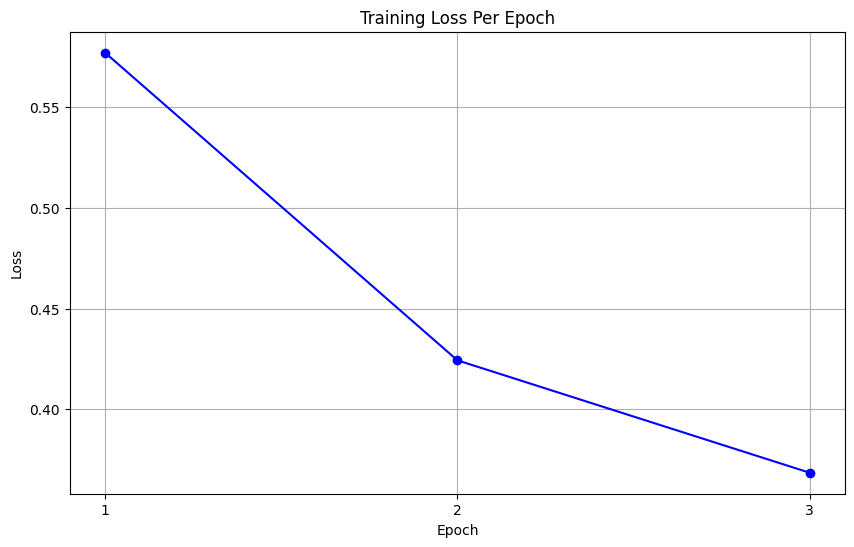

In [116]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), epoch_losses, marker='o', color='blue')
plt.title("Training Loss Per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, num_epochs+1))
plt.grid(True)
plt.show()


# Predicting on the test set

In [117]:
import pandas as pd
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import DataLoader, Dataset


model_path = '/content/drive/MyDrive/pittsburgh-annotation/hate_speech_best_model.pth'
tokenizer_path = 'dbmdz/bert-base-turkish-128k-cased'
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model, num_labels=1)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.to(device)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)


df = pd.read_csv("/content/drive/MyDrive/hate-speech-sabancı/TaskA_withoutLabels.csv")


class CSVTextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=max_seq_length):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoded = self.tokenizer.encode_plus(text, add_special_tokens=True, max_length=self.max_length, padding='max_length', return_attention_mask=True, truncation=True)
        return torch.tensor(encoded['input_ids']).to(device), torch.tensor(encoded['attention_mask']).to(device)

texts = df['Text'].tolist()
csv_dataset = CSVTextDataset(texts, tokenizer)
csv_loader = DataLoader(csv_dataset, batch_size=batch_size)

def predict(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for input_ids, attention_mask in data_loader:
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs.logits).squeeze()
            preds = (probs > 0.4).long().cpu().numpy()
            predictions.extend(preds)
    return predictions


predictions = predict(model, csv_loader)
df['Prediction'] = predictions


output_file_path = "/content/drive/MyDrive/pittsburgh-annotation/test_predicted.csv"

df.to_csv(output_file_path, index=False)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-128k-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [119]:
df = pd.read_csv("/content/drive/MyDrive/pittsburgh-annotation/test_predicted.csv")

In [125]:
df.drop(columns={"Text"},inplace=True)

In [126]:
df

,ID,Prediction
0,1425699068987252737,0
1,1623423660676489219,0
2,1290750188286619649,0
3,1568724242706882563,0
4,1624785800138264577,0
...,...,...
2287,1536992910427754502,1
2288,1624910775528693760,1
2289,1420279806806138885,1
2290,1556404183909253121,0


In [128]:
df.to_csv("/content/drive/MyDrive/pittsburgh-annotation/test_predicted.csv",index=False)